## Causal Analysis on the Breast Cancer Dataset

1. Split the Data into TRain and Test
2. Generate a ground truth graph
3. Create new causal graphs using increasing fractions of the data and compare with the ground truth graph
4. Compare each graph and select the best graph according to the jarcard score
5. Use the Markov blanket to get causal Inference
6. Bayesian Network

In [163]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.utils.network_utils import get_markov_blanket


from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Markdown, display, Image, display_html

In [120]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [121]:
import causalnex
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

from causalnex.structure import StructureModel
sm=StructureModel

### Loading the data

In [122]:
sys.path.append('../data')
sys.path.append('../scripts')
sys.path.append('../logs')
from Read_data import ReadData
from plot import Plot
from cleaning import Cleaner
from utils import Utils
from causality import Causal

In [123]:
loader=ReadData()
utils= Utils("../logs/modelling.logs")
causal=Causal("../logs/causal.logs")

Load the data

In [6]:
df=loader.read_csv('../data/clean_data.csv')

In [7]:
df.head()

,Unnamed: 0,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,target
0,0,0.331463,0.014414,0.377722,0.447309,0.226566,0.223546,0.116444,0.382418,0.393968,0.361727,1
1,1,0.703942,0.298340,0.317283,0.222856,0.171225,0.089011,0.099723,0.380408,0.169174,0.211213,1
2,2,0.467724,0.303467,0.399928,0.359650,0.178554,0.220804,0.098760,0.376041,0.299669,0.279738,1
3,3,0.114765,0.197114,0.443198,0.308971,0.075981,0.296740,0.156890,0.500092,0.444668,0.299705,1
4,4,0.563637,0.140108,0.385085,0.415120,0.209228,0.150256,0.130464,0.391360,0.154280,0.285883,1


In [53]:
df.drop(columns='Unnamed: 0')

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,target
0,0.331463,0.014414,0.377722,0.447309,0.226566,0.223546,0.116444,0.382418,0.393968,0.361727,1
1,0.703942,0.298340,0.317283,0.222856,0.171225,0.089011,0.099723,0.380408,0.169174,0.211213,1
2,0.467724,0.303467,0.399928,0.359650,0.178554,0.220804,0.098760,0.376041,0.299669,0.279738,1
3,0.114765,0.197114,0.443198,0.308971,0.075981,0.296740,0.156890,0.500092,0.444668,0.299705,1
4,0.563637,0.140108,0.385085,0.415120,0.209228,0.150256,0.130464,0.391360,0.154280,0.285883,1
...,...,...,...,...,...,...,...,...,...,...,...
564,0.511690,0.317999,0.390774,0.423785,0.285863,0.148474,0.085679,0.341970,0.132392,0.243264,1
565,0.539932,0.543981,0.353797,0.292728,0.205475,0.143212,0.048055,0.260289,0.138815,0.222793,1
566,0.444857,0.607054,0.281586,0.211804,0.122044,0.257290,0.101183,0.275734,0.267456,0.265600,1
567,0.331847,0.341601,0.302899,0.423886,0.114564,0.229402,0.094095,0.319008,0.419985,0.386006,1


### 1. Split the data into train and holdout

In [54]:
# Select the x and y (features and target variables)
y= df['target']
x = df.drop('target', axis=1)

In [55]:
# Use sklearn to split the dataset into train and test set 80:20
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [56]:
print("shape of original dataset :", df.shape)
print("shape of input - training set", x_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", x_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (569, 12)
shape of input - training set (455, 11)
shape of output - training set (455,)
shape of input - testing set (114, 11)
shape of output - testing set (114,)


In [58]:
#combine the train features and target into one dataframe
train_df = x_train.copy()
train_df['diagnosis'] = y_train

#combine the train features and target into one dataframe
test_df = x_test.copy()
test_df['diagnosis'] = y_test

#for testing
train_df.head()

,Unnamed: 0,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
252,252,0.383924,0.217545,0.307715,0.360330,0.150827,0.230899,0.139899,0.419467,0.350769,0.431421,1
147,147,0.453460,0.368375,0.312054,0.254940,0.135186,0.420049,0.351953,0.226518,0.262236,0.240076,0
318,318,0.090331,0.287807,0.393346,0.428528,0.118645,0.442677,0.223384,0.311457,0.312225,0.340910,0
463,463,0.322314,0.431295,0.431919,0.116313,0.037427,0.163419,0.095415,0.613684,0.219589,0.219037,0
226,226,0.236651,0.281096,0.687351,0.022500,0.041773,0.063067,0.096197,0.600735,0.123433,0.030470,0


In [62]:
test_df.drop(columns='Unnamed: 0', axis=1, inplace=True)
test_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
346,0.378924,0.489911,0.444429,0.027738,0.075064,0.103095,0.101252,0.600955,0.165036,0.056733,0
143,0.405563,0.304039,0.446200,0.166008,0.053894,0.145461,0.049626,0.573912,0.319560,0.241674,0
404,0.499287,0.348839,0.607606,0.097274,0.193754,0.092241,0.036535,0.437180,0.076682,0.077374,0
189,0.459346,0.381969,0.464038,0.164342,0.083718,0.272275,0.052335,0.463071,0.243791,0.207391,0
81,0.277100,0.191492,0.458571,0.252183,0.058180,0.231638,0.117954,0.501187,0.403595,0.357256,0


In [65]:
train_df.drop(columns='Unnamed: 0', axis=1, inplace=True)
train_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
252,0.383924,0.217545,0.307715,0.360330,0.150827,0.230899,0.139899,0.419467,0.350769,0.431421,1
147,0.453460,0.368375,0.312054,0.254940,0.135186,0.420049,0.351953,0.226518,0.262236,0.240076,0
318,0.090331,0.287807,0.393346,0.428528,0.118645,0.442677,0.223384,0.311457,0.312225,0.340910,0
463,0.322314,0.431295,0.431919,0.116313,0.037427,0.163419,0.095415,0.613684,0.219589,0.219037,0
226,0.236651,0.281096,0.687351,0.022500,0.041773,0.063067,0.096197,0.600735,0.123433,0.030470,0


### Save the train and test data

In [66]:
train_df.to_csv('../data/train_data.csv', index=False)

In [63]:
test_df.to_csv('../data/test_data.csv', index=False)

In [67]:
train_df= loader.read_csv('../data/train_data.csv')
train_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
0,0.383924,0.217545,0.307715,0.360330,0.150827,0.230899,0.139899,0.419467,0.350769,0.431421,1
1,0.453460,0.368375,0.312054,0.254940,0.135186,0.420049,0.351953,0.226518,0.262236,0.240076,0
2,0.090331,0.287807,0.393346,0.428528,0.118645,0.442677,0.223384,0.311457,0.312225,0.340910,0
3,0.322314,0.431295,0.431919,0.116313,0.037427,0.163419,0.095415,0.613684,0.219589,0.219037,0
4,0.236651,0.281096,0.687351,0.022500,0.041773,0.063067,0.096197,0.600735,0.123433,0.030470,0


### Causal Analysis

### 1. Ground Truth Graph

- Use The Train data to get a ground truth structure 
- NOTEARS library is used to learn the structure of the causal graph


In [8]:
train_df= loader.read_csv('../data/train_data.csv')
train_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
0,0.383924,0.217545,0.307715,0.360330,0.150827,0.230899,0.139899,0.419467,0.350769,0.431421,1
1,0.453460,0.368375,0.312054,0.254940,0.135186,0.420049,0.351953,0.226518,0.262236,0.240076,0
2,0.090331,0.287807,0.393346,0.428528,0.118645,0.442677,0.223384,0.311457,0.312225,0.340910,0
3,0.322314,0.431295,0.431919,0.116313,0.037427,0.163419,0.095415,0.613684,0.219589,0.219037,0
4,0.236651,0.281096,0.687351,0.022500,0.041773,0.063067,0.096197,0.600735,0.123433,0.030470,0


In [9]:
sm=causal.generate_structure(train_df)

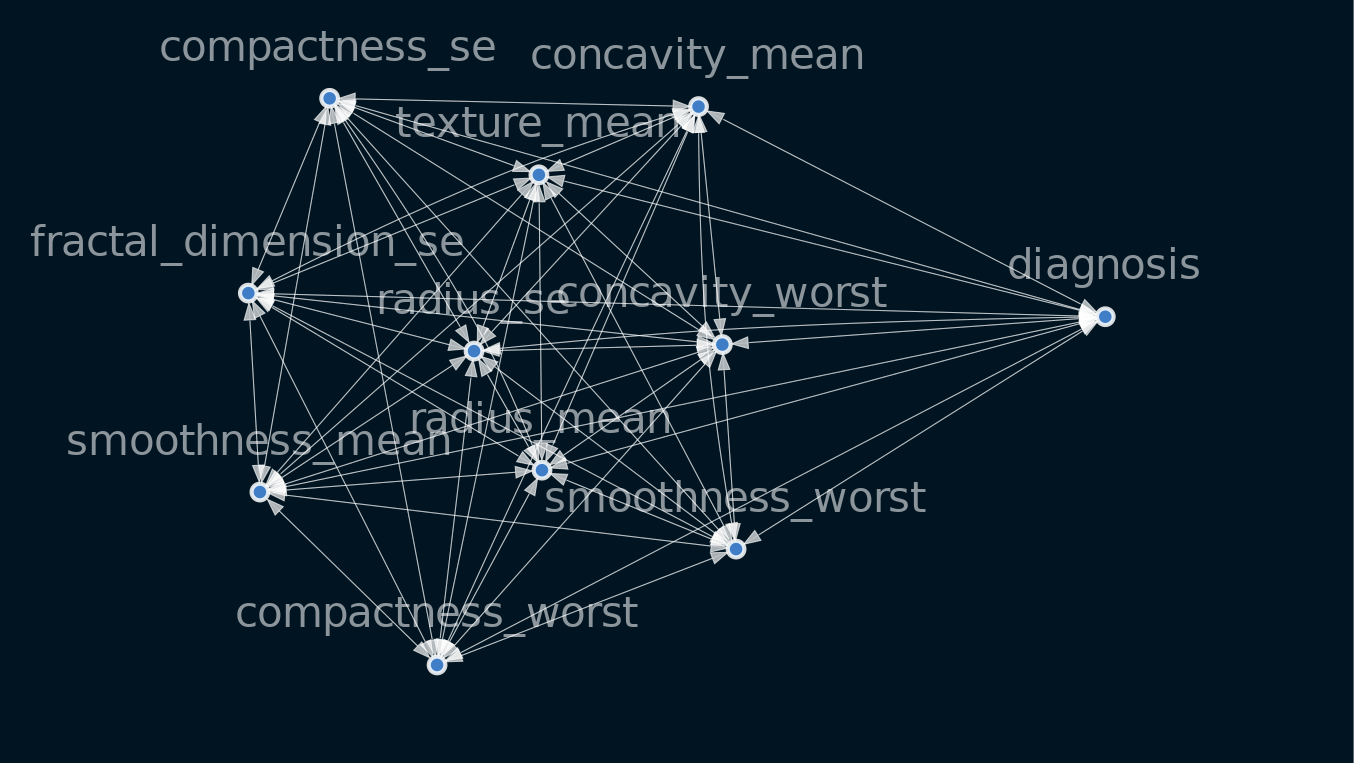

In [10]:
causal.visualize_structure(sm)

In [21]:
causal.remove_weak_edges(sm,0.8)

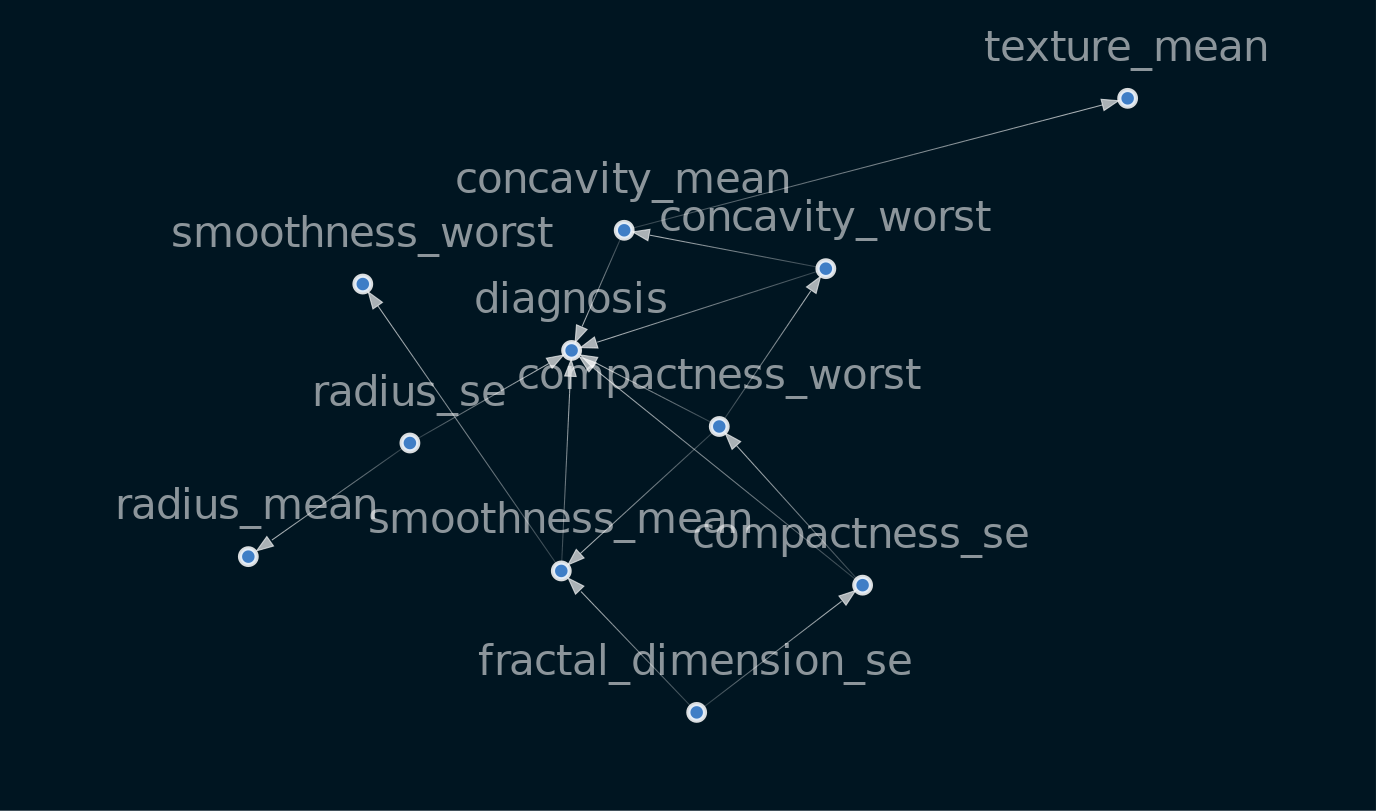

In [22]:
causal.visualize_structure(sm)

### 2. Create new causal graphs using increasing fractions of the data and compare with the ground truth graph

In [11]:
factor = len(train_df)/100
causal_20 = train_df.sample(int(20*factor), random_state=11)
print(f"size of causal_20 : {len(causal_20)}")
causal_40 = train_df.sample(int(40*factor), random_state=11)
print(f"size of causal_40 : {len(causal_40)}")
causal_60 = train_df.sample(int(60*factor), random_state=11)
print(f"size of causal_60 : {len(causal_60)}")
causal_80 = train_df.sample(int(80*factor), random_state=11)
print(f"size of causal_80 : {len(causal_80)}")
print(f"size of causal_100 : {len(train_df)}")

size of causal_20 : 91
size of causal_40 : 182
size of causal_60 : 273
size of causal_80 : 364
size of causal_100 : 455


In [12]:
sm20=causal.generate_structure(causal_20)

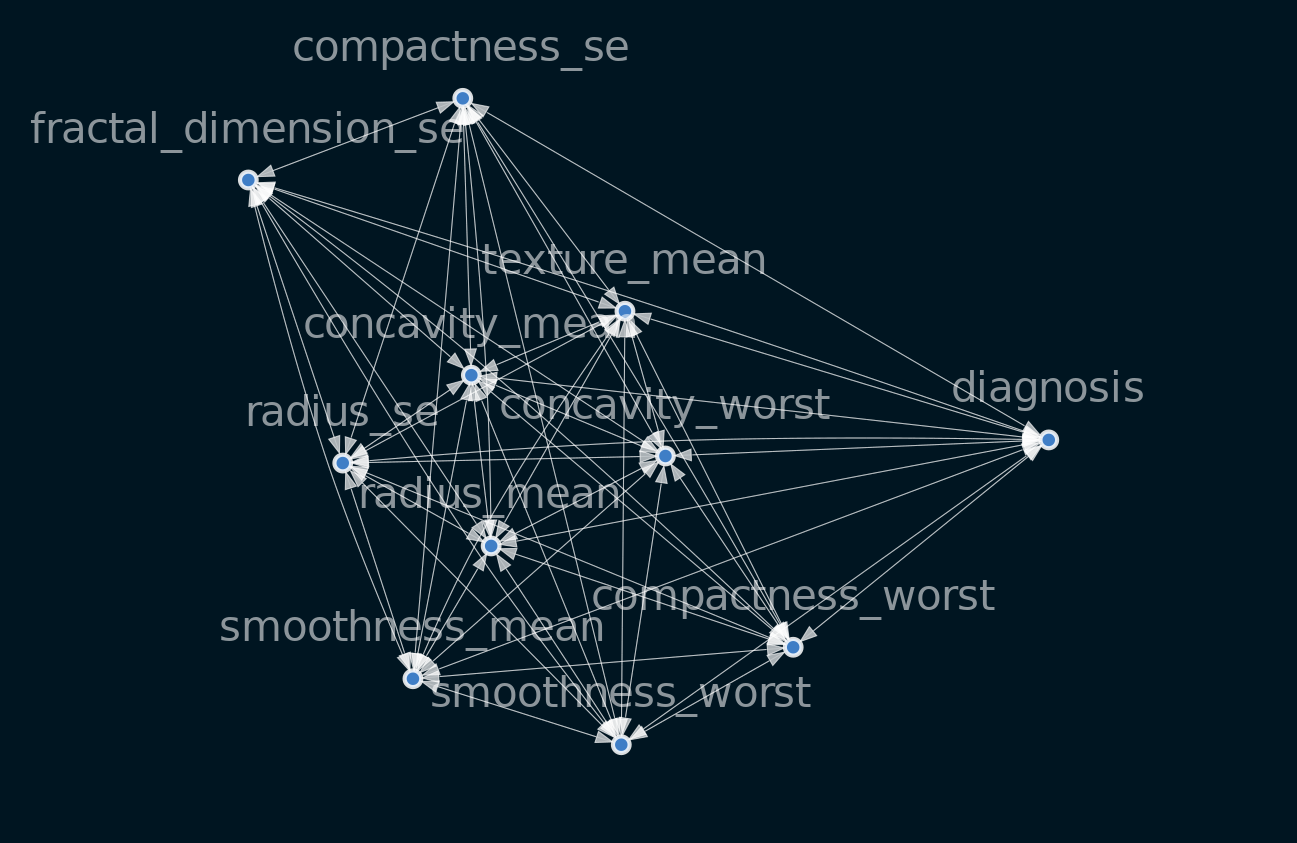

In [13]:
causal.visualize_structure(sm20)

In [23]:
causal.remove_weak_edges(sm20,0.8)

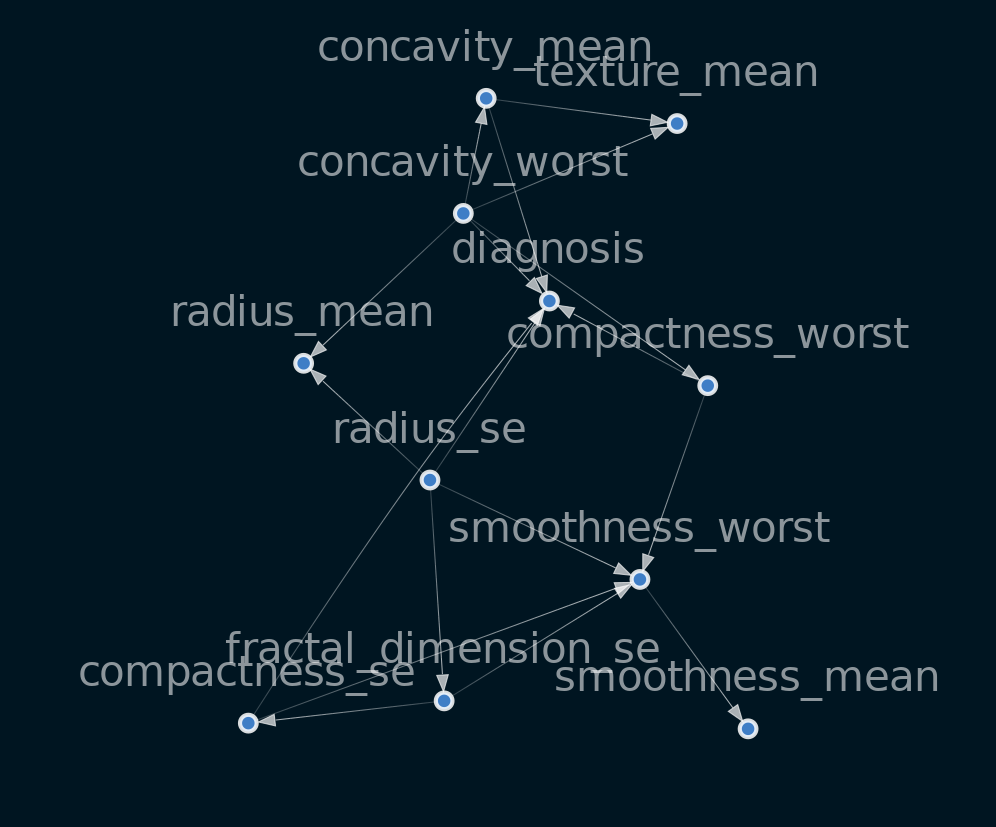

In [24]:
causal.visualize_structure(sm20)

In [14]:
sm40=causal.generate_structure(causal_40)

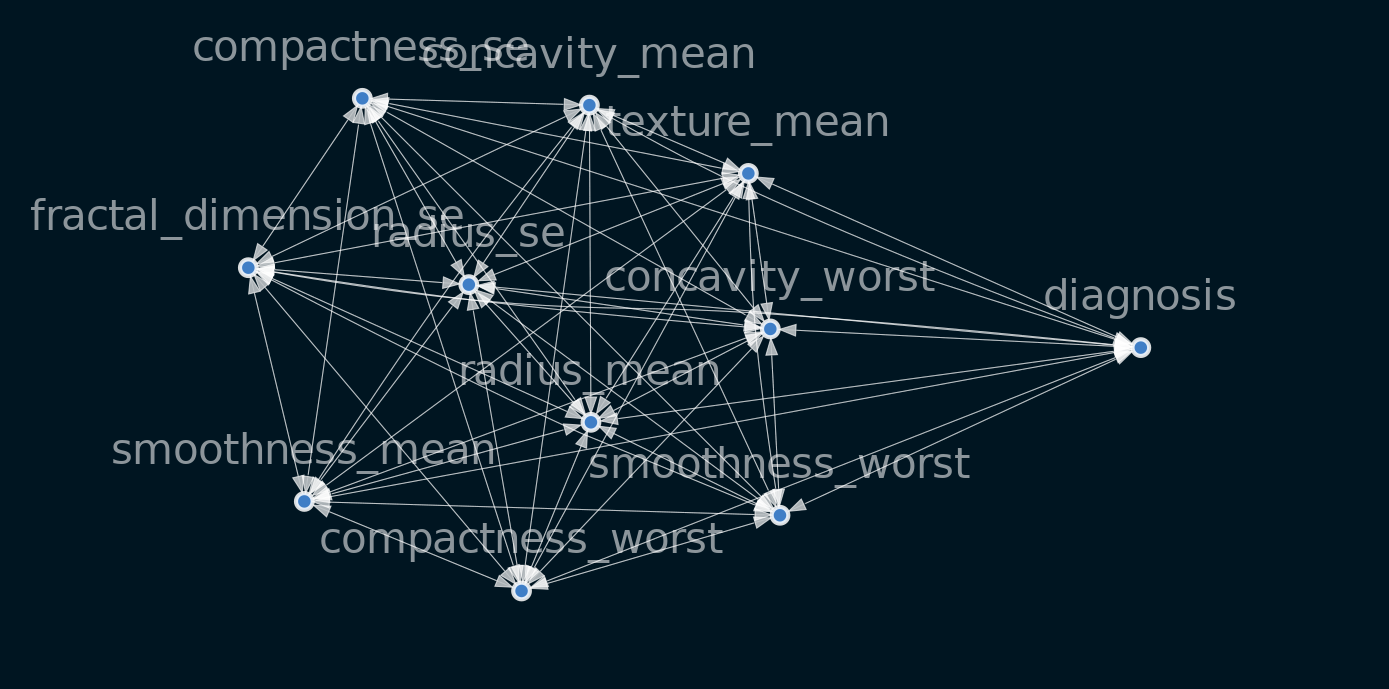

In [16]:
causal.visualize_structure(sm40)

In [27]:
causal.remove_weak_edges(sm40,0.8)

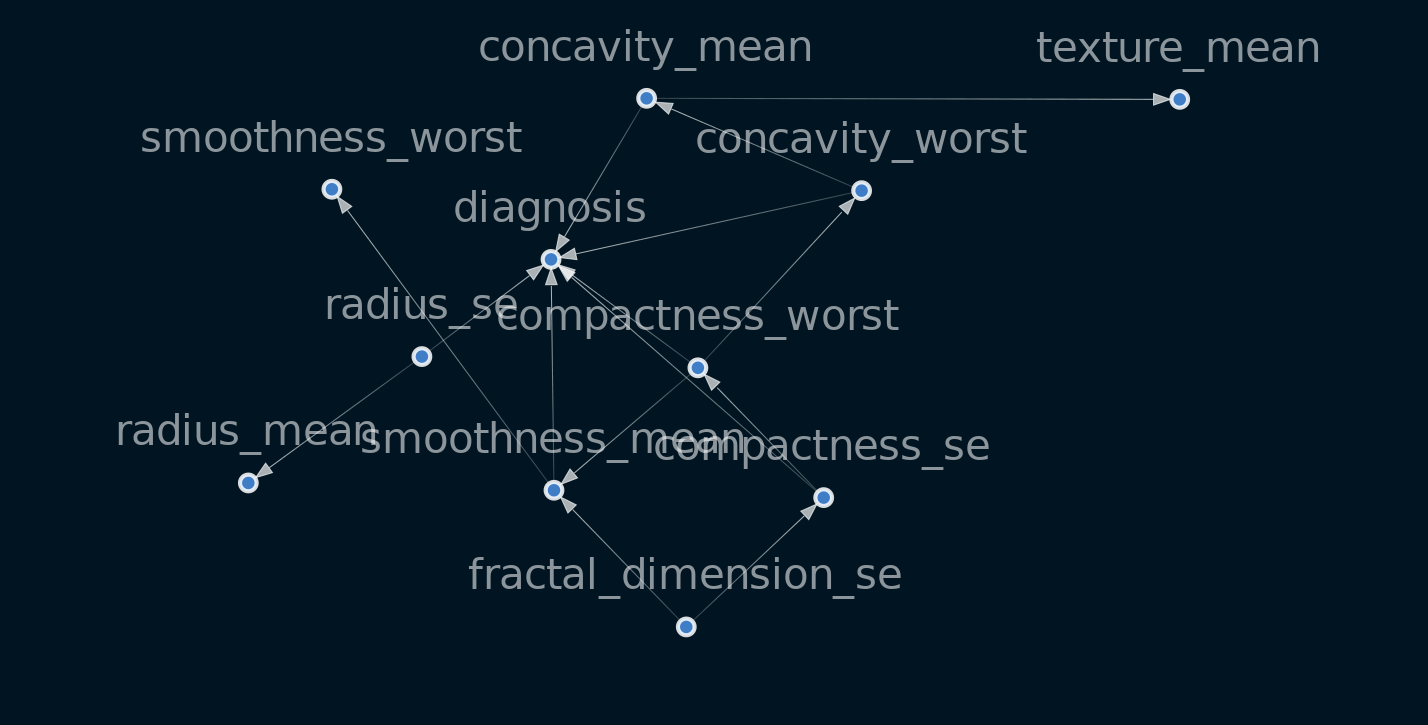

In [28]:
causal.visualize_structure(sm40)

In [17]:
sm60= causal.generate_structure(causal_60)

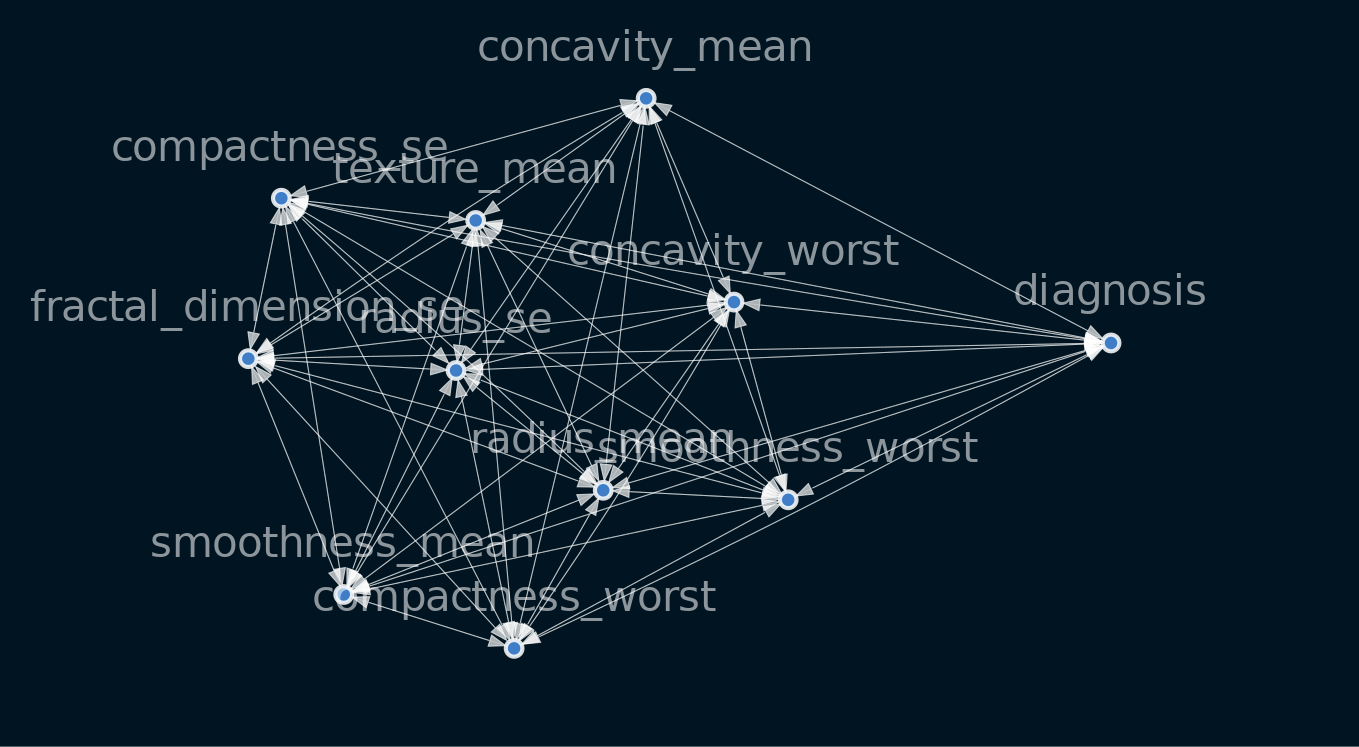

In [18]:
causal.visualize_structure(sm60)

In [30]:
causal.remove_weak_edges(sm60,0.8)

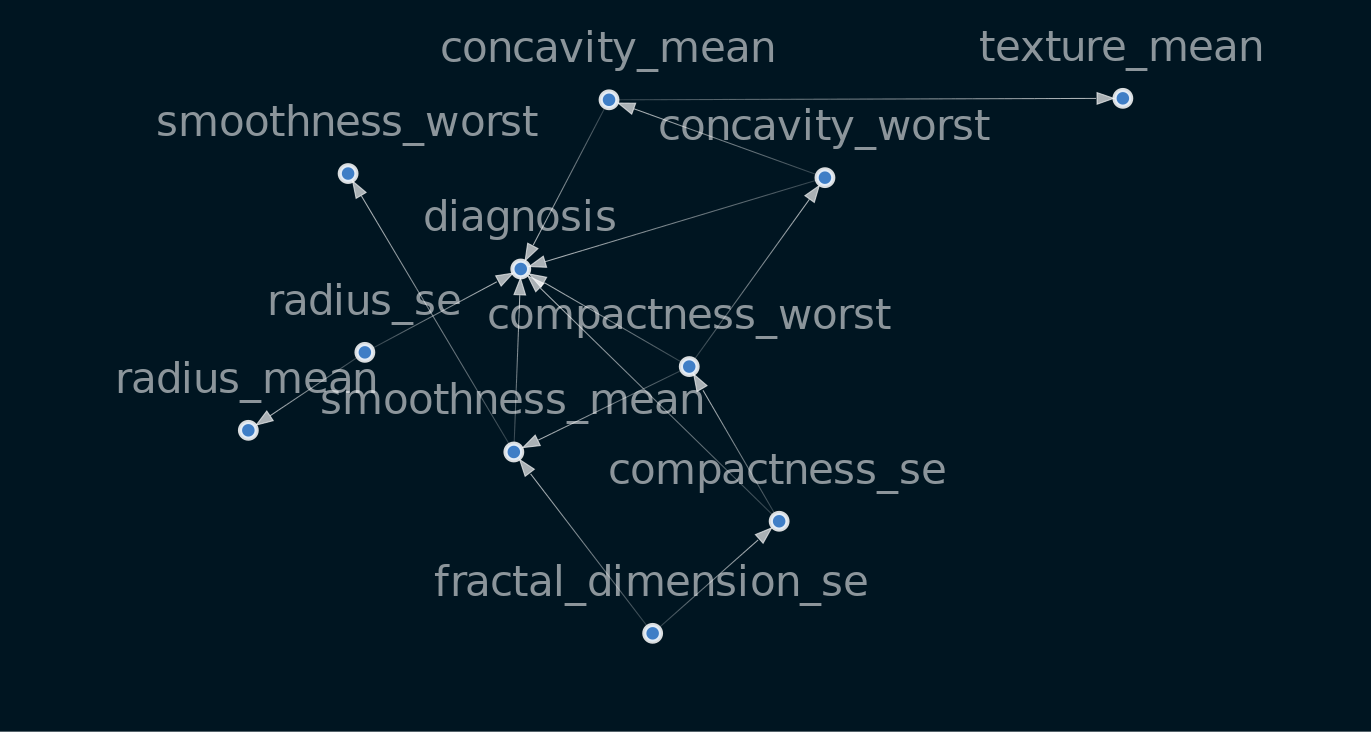

In [31]:
causal.visualize_structure(sm60)

In [19]:
sm80=causal.generate_structure(causal_80)

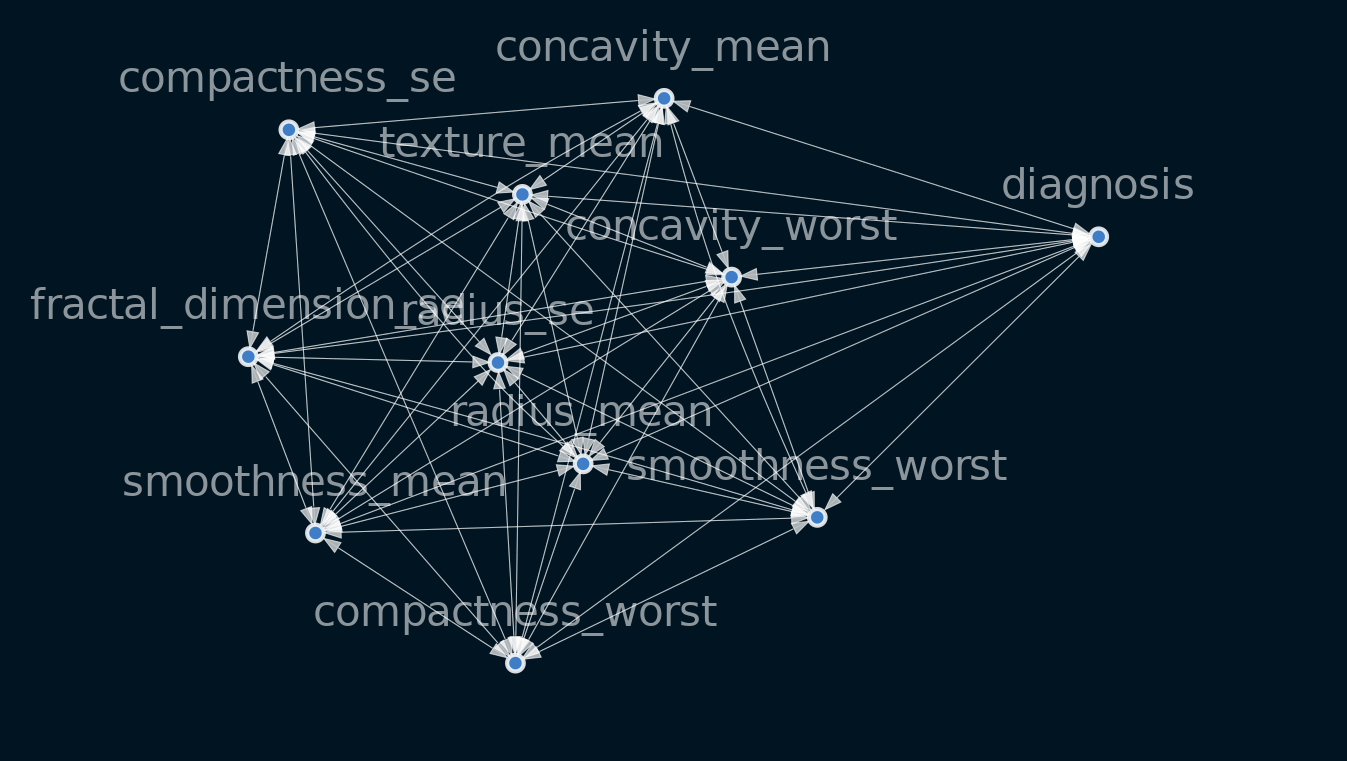

In [20]:
causal.visualize_structure(sm80)

In [32]:
causal.remove_weak_edges(sm80,0.8)

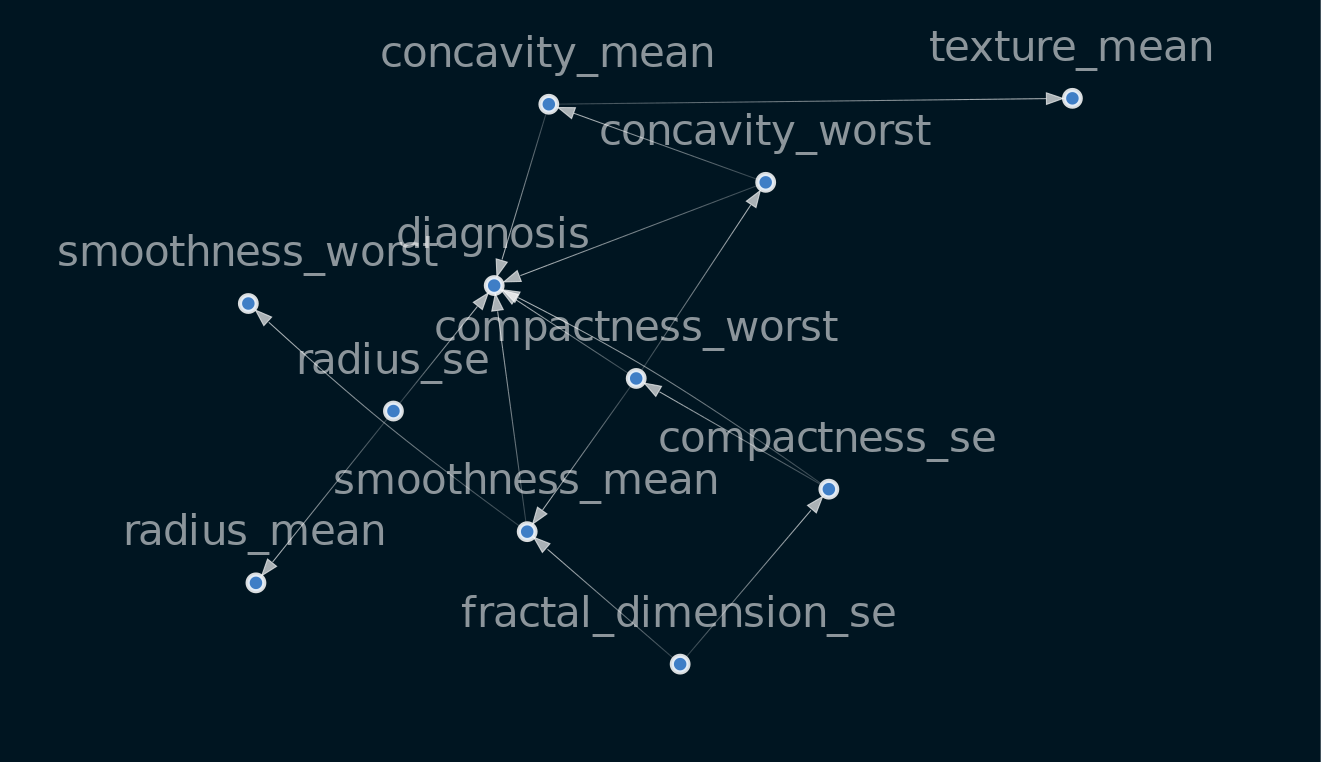

In [33]:
causal.visualize_structure(sm80)

### Comparing the Graphs' edges using Jaccard index
1. get the edges of each graph into a numpy array
2. convert each result to a 1D array and compae the edges

A high jaccard index (closer to one)indicates a better score

INFO:utils:jaccard index successfully calculated
INFO:utils:treshold successfully applied


The similarity index: 0.38


INFO:utils:graph successfully generated


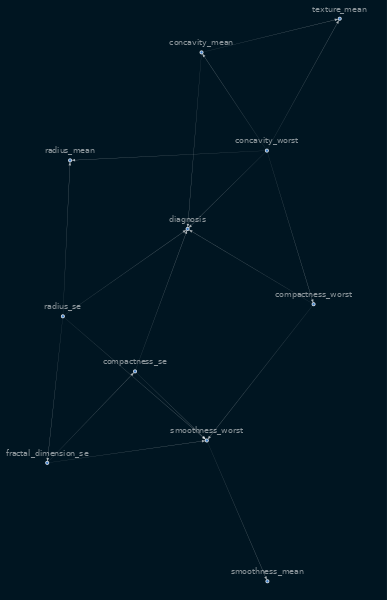

In [34]:
print(utils.jacc_index(sm,sm20, 0.8, 0.8))
utils.plot_graph(sm20, 0.8, True, "sm20_graph.png")

INFO:utils:jaccard index successfully calculated
INFO:utils:treshold successfully applied


The similarity index: 1.0


INFO:utils:graph successfully generated


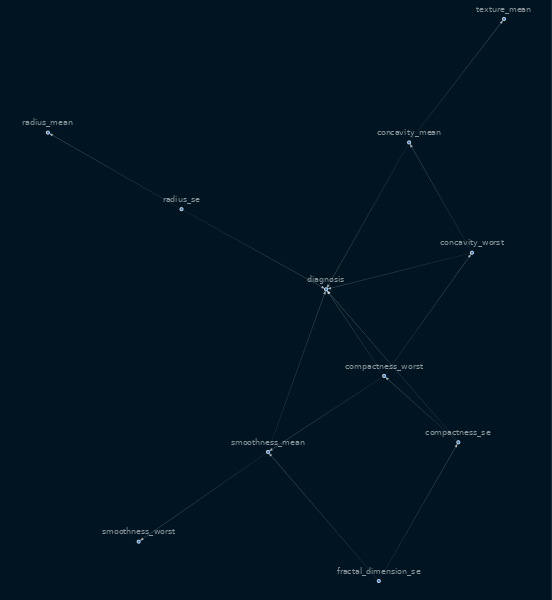

In [36]:
print(utils.jacc_index(sm,sm60, 0.8, 0.8))
utils.plot_graph(sm60, 0.8, True, "sm40_graph.png")

INFO:utils:jaccard index successfully calculated
INFO:utils:treshold successfully applied


The similarity index: 1.0


INFO:utils:graph successfully generated


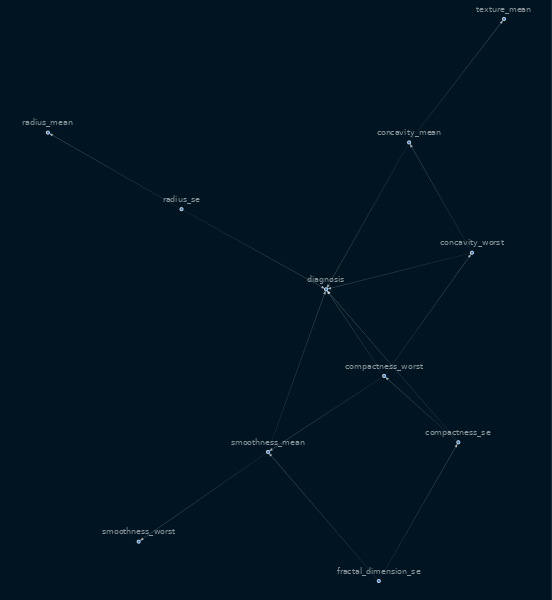

In [35]:
print(utils.jacc_index(sm,sm40, 0.8, 0.8))
utils.plot_graph(sm40, 0.8, True, "sm40_graph.png")

INFO:utils:jaccard index successfully calculated
INFO:utils:treshold successfully applied


The similarity index: 1.0


INFO:utils:graph successfully generated


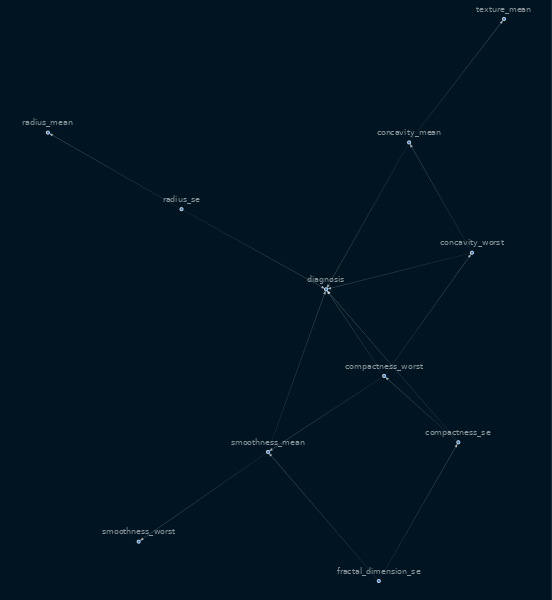

In [37]:
print(utils.jacc_index(sm,sm80, 0.8, 0.8))
utils.plot_graph(sm60, 0.8, True, "sm40_graph.png")

4. Markov's Blanket

In [38]:
bn = BayesianNetwork(sm)
blanket = get_markov_blanket(bn, 'diagnosis')
edge_list = list(blanket.structure.edges)

In [42]:
node_list=list(blanket.structure.nodes)

In [44]:
edge_list

[('smoothness_mean', 'diagnosis'),
 ('concavity_mean', 'diagnosis'),
 ('radius_se', 'diagnosis'),
 ('compactness_se', 'compactness_worst'),
 ('compactness_se', 'diagnosis'),
 ('compactness_worst', 'smoothness_mean'),
 ('compactness_worst', 'concavity_worst'),
 ('compactness_worst', 'diagnosis'),
 ('concavity_worst', 'concavity_mean'),
 ('concavity_worst', 'diagnosis')]

In [43]:
node_list

['smoothness_mean',
 'concavity_mean',
 'radius_se',
 'compactness_se',
 'compactness_worst',
 'concavity_worst',
 'diagnosis']

## Modelling

1. Data Versioning

In [45]:
train_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
0,0.383924,0.217545,0.307715,0.360330,0.150827,0.230899,0.139899,0.419467,0.350769,0.431421,1
1,0.453460,0.368375,0.312054,0.254940,0.135186,0.420049,0.351953,0.226518,0.262236,0.240076,0
2,0.090331,0.287807,0.393346,0.428528,0.118645,0.442677,0.223384,0.311457,0.312225,0.340910,0
3,0.322314,0.431295,0.431919,0.116313,0.037427,0.163419,0.095415,0.613684,0.219589,0.219037,0
4,0.236651,0.281096,0.687351,0.022500,0.041773,0.063067,0.096197,0.600735,0.123433,0.030470,0


In [124]:
def filter_data(data, columns):
    '''
    Select specific columns in data
    args:
        data: The original DataFrame with all the features
        columns: A list of columns to select from the dataframe  
    '''
    return data.filter(columns, axis=1)

In [47]:
columns=['smoothness_mean',
 'concavity_mean',
 'radius_se',
 'compactness_se',
 'compactness_worst',
 'concavity_worst',
 'diagnosis']

In [49]:
train_df2=filter_data(train_df,columns)

In [50]:
train_df2.head()

,smoothness_mean,concavity_mean,radius_se,compactness_se,compactness_worst,concavity_worst,diagnosis
0,0.307715,0.360330,0.150827,0.230899,0.350769,0.431421,1
1,0.312054,0.254940,0.135186,0.420049,0.262236,0.240076,0
2,0.393346,0.428528,0.118645,0.442677,0.312225,0.340910,0
3,0.431919,0.116313,0.037427,0.163419,0.219589,0.219037,0
4,0.687351,0.022500,0.041773,0.063067,0.123433,0.030470,0


In [51]:
train_df2.to_csv('../data/selected_train.csv', index=False)

### Modelling with the data with all the features

In [60]:
log_model= LogisticRegression()

In [64]:
df =loader.read_csv('../data/clean_data.csv')
df.drop('Unnamed: 0', axis= 1)

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,target
0,0.331463,0.014414,0.377722,0.447309,0.226566,0.223546,0.116444,0.382418,0.393968,0.361727,1
1,0.703942,0.298340,0.317283,0.222856,0.171225,0.089011,0.099723,0.380408,0.169174,0.211213,1
2,0.467724,0.303467,0.399928,0.359650,0.178554,0.220804,0.098760,0.376041,0.299669,0.279738,1
3,0.114765,0.197114,0.443198,0.308971,0.075981,0.296740,0.156890,0.500092,0.444668,0.299705,1
4,0.563637,0.140108,0.385085,0.415120,0.209228,0.150256,0.130464,0.391360,0.154280,0.285883,1
...,...,...,...,...,...,...,...,...,...,...,...
564,0.511690,0.317999,0.390774,0.423785,0.285863,0.148474,0.085679,0.341970,0.132392,0.243264,1
565,0.539932,0.543981,0.353797,0.292728,0.205475,0.143212,0.048055,0.260289,0.138815,0.222793,1
566,0.444857,0.607054,0.281586,0.211804,0.122044,0.257290,0.101183,0.275734,0.267456,0.265600,1
567,0.331847,0.341601,0.302899,0.423886,0.114564,0.229402,0.094095,0.319008,0.419985,0.386006,1


In [65]:
# Select the x and y (features and target variables)
y= df['target']
x = df.drop('target', axis=1)

In [66]:
# Use sklearn to split the dataset into train and test set 80:20
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [67]:
log_model.fit(x_train, y_train)

LogisticRegression()

In [68]:
prediction=log_model.predict(x_test)

In [71]:
y_pred = log_model.predict(x_test)
print('Accuracy of logistic regression classifier on all features test set: {:.4f}'.format(log_model.score(x_test, y_test)))

Accuracy of logistic regression classifier on all features test set: 0.9123


Modelling with the features from Causal Inference

In [73]:
df2 =loader.read_csv('../data/selected_train.csv')
df.head()

,smoothness_mean,concavity_mean,radius_se,compactness_se,compactness_worst,concavity_worst,diagnosis
0,0.307715,0.360330,0.150827,0.230899,0.350769,0.431421,1
1,0.312054,0.254940,0.135186,0.420049,0.262236,0.240076,0
2,0.393346,0.428528,0.118645,0.442677,0.312225,0.340910,0
3,0.431919,0.116313,0.037427,0.163419,0.219589,0.219037,0
4,0.687351,0.022500,0.041773,0.063067,0.123433,0.030470,0


In [74]:
# Select the x and y (features and target variables)
y= df['diagnosis']
x = df.drop('diagnosis', axis=1)

In [75]:
# Use sklearn to split the dataset into train and test set 80:20
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [76]:
log_model.fit(x_train, y_train)

LogisticRegression()

In [77]:
y_pred_o = log_model.predict(x_test)
print('Accuracy of logistic regression classifier on all features test set: {:.4f}'.format(log_model.score(x_test, y_test)))

Accuracy of logistic regression classifier on all features test set: 0.8132


### Bayesian Network

In [125]:
columns=['smoothness_mean',
 'concavity_mean',
 'radius_se',
 'compactness_se',
 'compactness_worst',
 'concavity_worst',
 'diagnosis']

In [145]:
causal_df=loader.read_csv('../data/train_data.csv')

In [146]:
causal_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
0,0.383924,0.217545,0.307715,0.360330,0.150827,0.230899,0.139899,0.419467,0.350769,0.431421,1
1,0.453460,0.368375,0.312054,0.254940,0.135186,0.420049,0.351953,0.226518,0.262236,0.240076,0
2,0.090331,0.287807,0.393346,0.428528,0.118645,0.442677,0.223384,0.311457,0.312225,0.340910,0
3,0.322314,0.431295,0.431919,0.116313,0.037427,0.163419,0.095415,0.613684,0.219589,0.219037,0
4,0.236651,0.281096,0.687351,0.022500,0.041773,0.063067,0.096197,0.600735,0.123433,0.030470,0


Separate the causal analysis columns into a new data version

In [147]:
filtered_data= filter_data(causal_df, columns)

In [148]:
filtered_data.head()

,smoothness_mean,concavity_mean,radius_se,compactness_se,compactness_worst,concavity_worst,diagnosis
0,0.307715,0.360330,0.150827,0.230899,0.350769,0.431421,1
1,0.312054,0.254940,0.135186,0.420049,0.262236,0.240076,0
2,0.393346,0.428528,0.118645,0.442677,0.312225,0.340910,0
3,0.431919,0.116313,0.037427,0.163419,0.219589,0.219037,0
4,0.687351,0.022500,0.041773,0.063067,0.123433,0.030470,0


In [149]:
sm_full= causal.generate_structure(causal_df)
sm_filtered= causal.generate_structure(filtered_data)

In [150]:
columns_full=df.columns.to_list()

In [151]:
discretised_full_data=utils.data_descretiser(causal_df,columns_full, 'diagnosis')
discretised_filtered_data= utils.data_descretiser(filtered_data,columns,'diagnosis')

INFO:utils:successfully descretised dataframe
INFO:utils:successfully descretised dataframe


In [153]:
discretised_filtered_data.head()

,smoothness_mean,concavity_mean,radius_se,compactness_se,compactness_worst,concavity_worst,diagnosis
0,1,3,2,2,2,3,1
1,1,2,2,3,2,2,0
2,1,3,2,3,2,3,0
3,1,0,1,2,1,1,0
4,3,0,1,1,0,0,0


In [166]:
discretised_full_data.head()


,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
0,2,0,1,3,2,2,1,1,2,3,1
1,2,1,1,2,2,3,3,0,2,2,0
2,0,1,1,3,2,3,3,1,2,3,0
3,1,1,1,0,1,2,1,3,1,1,0
4,1,1,3,0,1,1,1,3,0,0,0


In [154]:
# split dataset.
train_o, test_o = train_test_split( discretised_full_data, train_size=0.8, test_size=0.2, random_state=27)
train_f, test_f = train_test_split( discretised_filtered_data, train_size=0.8, test_size=0.2, random_state=27)

In [156]:
bn1 = BayesianNetwork(blanket.structure)
bn1 = bn1.fit_node_states(discretised_full_data)
bn1 = bn1.fit_cpds(train_o, method="BayesianEstimator", bayes_prior="K2")

In [157]:
bn2 = BayesianNetwork(blanket.structure)
bn2 = bn2.fit_node_states(discretised_full_data)
bn2 = bn2.fit_cpds(train_f, method="BayesianEstimator", bayes_prior="K2")

In [159]:
pred1=bn1.predict(test_o,'diagnosis')
pred2=bn2.predict(test_f,'diagnosis')

In [160]:
test_o

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
134,1,1,2,0,0,2,1,2,3,3,0
347,2,2,2,0,2,2,1,2,1,0,0
95,1,1,1,0,1,2,1,3,1,1,0
361,2,1,1,0,1,2,1,2,2,0,0
131,1,3,1,0,1,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,3,1,1,3,3,2,1,0,0
265,3,0,1,1,1,2,1,2,2,3,0
319,2,1,1,3,2,2,1,1,2,3,1
393,1,0,3,2,2,2,1,1,0,0,0


In [161]:
true_1= test_o['diagnosis']
true_2= test_f['diagnosis']

In [164]:
print('Recall: {:.2f}'.format(recall_score(y_true=true_1, y_pred=pred1)))
print('F1: {:.2f} '.format(f1_score(y_true=true_1, y_pred=pred1)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true_1, y_pred=pred1)))
print('Precision: {:.2f} '.format(precision_score(y_true=true_1, y_pred=pred1)))

Recall: 0.82
F1: 0.87 
Accuracy: 0.91 
Precision: 0.93 


In [165]:
print('Recall: {:.2f}'.format(recall_score(y_true=true_2, y_pred=pred2)))
print('F1: {:.2f} '.format(f1_score(y_true=true_2, y_pred=pred1)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true_2, y_pred=pred2)))
print('Precision: {:.2f} '.format(precision_score(y_true=true_2, y_pred=pred2)))

Recall: 0.82
F1: 0.87 
Accuracy: 0.91 
Precision: 0.93 
